In [16]:
using EPhys, PyPlot

In [ ]:
bsnms = ["mam5-160307";
    "mam9-160528"; "mam9-160524"; "mam9-160527";
    "mam10-170213"]
dataloc = "/mnfs/vtad1/data/amorley_merged/"
allmetadata = getmetadata.(bsnms, [dataloc])
allsessions = [find(contains.(x["desen"],"sq flicker"))
    for x in allmetadata]

In [6]:
day = 1
bsnm = bsnms[day]
sessions = allsessions[day]
metadata = allmetadata[day]

Dict{String,Any} with 27 entries:
  "toneSucrose"     => Dict{Any,Any}(Pair{Any,Any}(4, [1217321 1419433; 2757958…
  "licking"         => Dict{Any,Any}(Pair{Any,Any}(4, [2364050 2365314; 2370954…
  "whlscale"        => 4.0
  "tracking"        => Dict{Any,Any}(Pair{Any,Any}(2, [247307 247634; 248096 24…
  "resofs"          => [24134144; 46813184; … ; 269031936; 277045760]
  "bsnm"            => "mam5-160307"
  "numcells"        => 34
  "cellIDs"         => String["p1", "b1", "p1", "p1", "p1", "p1", "b1", "bbla",…
  "dropRemoval"     => Dict{Any,Any}(Pair{Any,Any}(4, [1709812 1825168; 3250447…
  "solenoidSucrose" => Dict{Any,Any}(Pair{Any,Any}(4, [1401863 1409792; 2942493…
  "seslengths"      => [24134144; 22679040; … ; 11063808; 8013824]
  "toneQuinine"     => Dict{Any,Any}(Pair{Any,Any}(10, [974466 1176245; 2088921…
  "numchan"         => 58
  "fs"              => 20000.0
  "LEDstrip"        => Dict{Any,Any}(Pair{Any,Any}(4, [72220 13643398; 13716842…
  "solenoidQuinine" => Dict{Any,An

In [7]:
lfp = load(LFP,metadata,sessions)

EPhys.LFP{Int16}(EPhys.Signal{Int16}[EPhys.Signal{Int16}(Int16[-150, -29, 21, 49, 107, 247, 408, 509, 645, 787  …  -841, -654, -363, -104, 127, -15, -160, -95, -276, -295], 1250.0), EPhys.Signal{Int16}(Int16[-389, -469, -601, -590, -572, -511, -479, -480, -426, -447  …  -388, -457, -534, -492, -357, -561, -629, -372, -438, -481], 1250.0), EPhys.Signal{Int16}(Int16[-480, -495, -624, -728, -719, -690, -607, -550, -560, -627  …  -209, -235, -374, -450, -291, -416, -541, -343, -448, -417], 1250.0), EPhys.Signal{Int16}(Int16[-722, -734, -828, -906, -907, -825, -746, -698, -681, -735  …  -564, -582, -606, -666, -627, -800, -862, -676, -799, -788], 1250.0), EPhys.Signal{Int16}(Int16[-740, -737, -773, -781, -741, -676, -586, -491, -433, -487  …  -400, -421, -439, -485, -382, -527, -642, -520, -635, -585], 1250.0), EPhys.Signal{Int16}(Int16[-352, -343, -427, -464, -422, -314, -248, -205, -179, -269  …  -576, -553, -532, -468, -408, -673, -835, -688, -760, -675], 1250.0), EPhys.Signal{Int16}(Int

In [143]:
testsignal = EPhys.signal(lfp.lfp[1])[1:10*floor(Int,lfp.fs)];

In [174]:
include("$EPhysLP/../../../EMD/src/EMD.jl")

EMD

In [1]:
N = 9

C = EMD.IMF(testsignal, t, N=N)
fig,axs = subplots(size(C,2),1,figsize=(10,10))

for i in indices(C,2)
    ax = axs[i]
    ax[:plot](C[:,i])
end

LoadError: [91mUndefVarError: EMD not defined[39m

In [144]:
n = length(testsignal)

#Tukey window
alpha = 0.25
window = zeros(n)
for i = 0:n-1
    if i < alpha * (n-1)/2
        window[i+1] = 0.5*(1 + cos(pi*(2*i/(alpha*(n-1)) - 1)))
    elseif i < (n-1)*(1-alpha/2)
        window[i+1] = 1
    else
        window[i+1] = 0.5*(1 + cos(pi*(2*i/(alpha*(n-1)) + 1 - 2/alpha)))
    end
end

In [145]:
(y, t) = testsignal, [linspace(0,n,n);]
toldev=0.01;
tolzero = 0.01;
order=4; N=10; window=0

0

In [163]:
if window==0
    window = ones(length(t))
end

n = length(y)
f = zeros(n,N)
tempy = copy(y)
eps = 0.00001

n_modes = 0;

for i = 1:N
    avg = zeros(n,1)+1
    sd = 2*toldev

    while(mean(abs.(avg))>tolzero && sd > toldev)

        # Interpolate a spline through the maxima and minima
        max_ar, min_ar, tmax, tmin = findExtrema(tempy, t)

        # # Don't use too high an order to interpolate, restrict it if there are not many extrema
        # p_max = min(order, length(max_ar)-2)
        # p_min = min(order, length(min_ar)-2)

        # # Make even order
        # p_max = Int(2*floor(p_max/2))
        # p_min = Int(2*floor(p_min/2))

        # # At least linear
        # p_max = max(p_max,2)
        # p_min = max(p_min,2)
        p_max = (length(max_ar) >= order) ? order : 4
        p_min = (length(min_ar) >= order) ? order : 4

        while true
            p_min = p_min < length(min_ar) ? (p_min; break) : (p_min - 1)
            p_max = p_max < length(max_ar) ? (p_max; break) : (p_max - 1)
        end
            
        S1 = Spline1D(tmax, max_ar, k = p_max)
        S2 = Spline1D(tmin, min_ar, k = p_min)

        # Find mean of envelope
        avg = (S1(t) + S2(t)) / 2
        avg = avg.*window

        tempy = tempy-avg

        sd = mean( (avg.^2)./((y-f[:,i]).^2 + eps) )

        f[:,i] = f[:,i] + avg

        #println(sd)
    end

    tempy = copy(f[:,i])

    # Check to see if it's worth continuing or if the remainder is monotone
    c = mean(abs.(tempy))
    d = diff(tempy)
    n_modes = n_modes + 1
    if all(d+c*tolzero .> 0) || all(d-c*tolzero .< 0)
        break
    end
end

C = zeros(n,N)
C[:,1] = y - f[:,1]
for i = 2:n_modes
    C[:,i] = f[:,i-1]-f[:,i]
end

return C

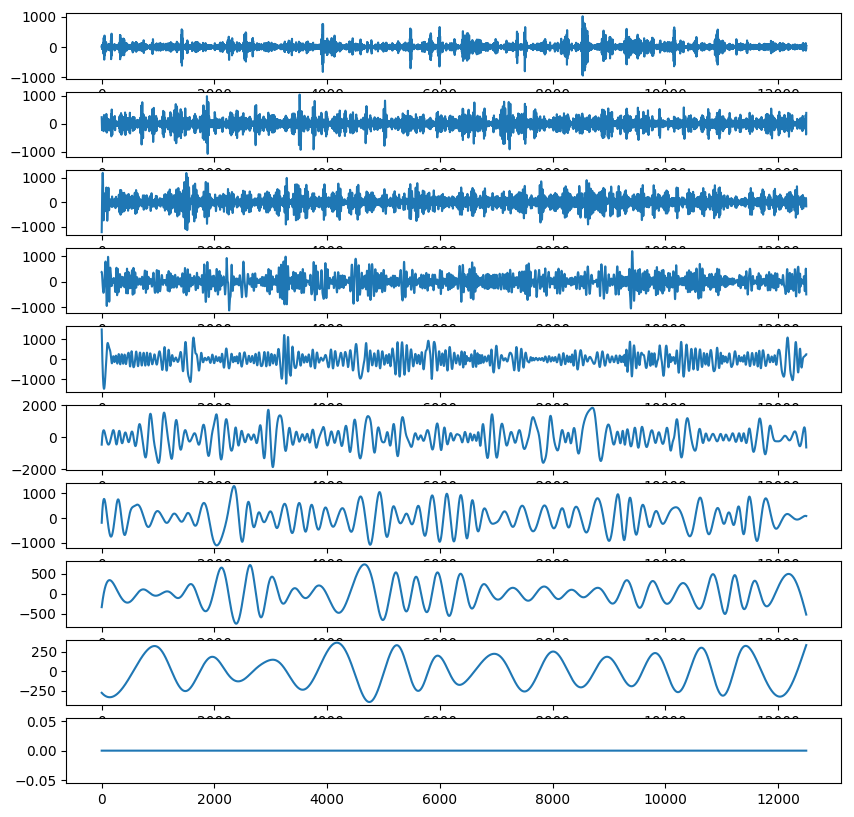

In [121]:
using StatsBase

In [100]:
itp = scale(interpolate(min_ar, (BSpline(Cubic(Natural())), NoInterp()), OnGrid(), 1)

LoadError: [91mMethodError: no method matching interpolate(::Array{Float64,1}, ::Tuple{Interpolations.BSpline{Interpolations.Cubic{Interpolations.Line}},Interpolations.NoInterp}, ::Interpolations.OnGrid, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}})[0m
Closest candidates are:
  interpolate(::AbstractArray, ::IT<:Union{Interpolations.BSpline, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.BSpline, Interpolations.NoInterp},N} where N}}, ::GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}}) where {IT<:Union{Interpolations.BSpline, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.BSpline, Interpolations.NoInterp},N} where N}}, GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}}} at /home/data/.julia/v0.6/Interpolations/src/b-splines/b-splines.jl:77
  interpolate(::AbstractArray, [91m::Interpolations.NoInterp[39m, ::GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}}) where GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}} at /home/data/.julia/v0.6/Interpolations/src/nointerp/nointerp.jl:2
  interpolate([91m::Type{TWeights}[39m, [91m::Type{TC}[39m, ::Any, [91m::IT<:Union{Interpolations.BSpline, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.BSpline, Interpolations.NoInterp},N} where N}}[39m, [91m::GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}}[39m) where {TWeights, TC, IT<:Union{Interpolations.BSpline, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.BSpline, Interpolations.NoInterp},N} where N}}, GT<:Union{Interpolations.GridType, Interpolations.NoInterp, Tuple{Vararg{Union{Interpolations.GridType, Interpolations.NoInterp},N} where N}}} at /home/data/.julia/v0.6/Interpolations/src/b-splines/b-splines.jl:73
  ...[39m

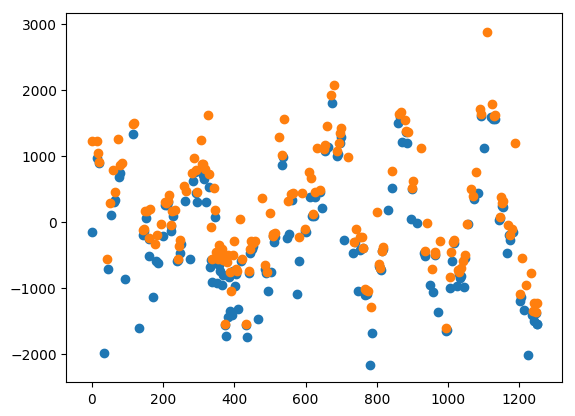

PyObject <matplotlib.collections.PathCollection object at 0x7f1cbf362e10>

In [95]:
scatter(tmin, min_ar, label="minima")
scatter(tmax, max_ar, label="maxima")

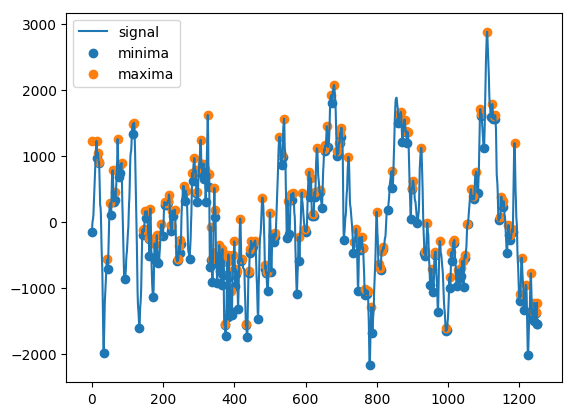

PyObject <matplotlib.legend.Legend object at 0x7f1cbf48e390>

In [94]:
scatter(tmin, min_ar, label="minima")
scatter(tmax, max_ar, label="maxima")
plot(t,testsignal, label = "signal")

legend()

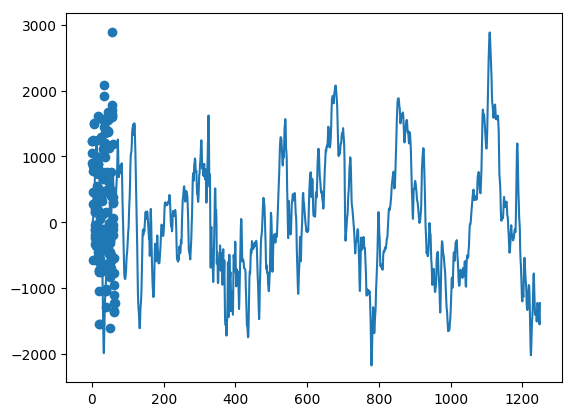

PyObject <matplotlib.collections.PathCollection object at 0x7f1cc018f250>

In [60]:
plot(tempy)


In [39]:
EMD.IMF(testsignal,window)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs(::Array{Float64,2}) at ./deprecated.jl:57
 [3] IMF(::Array{Int16,1}, ::Array{Float64,1}, ::Float64, ::Float64, ::Int64, ::Int64, ::Int64) at /ddLab/code/amorley/julia/EMD/src/IMF.jl:20
 [4] IMF(::Array{Int16,1}, ::Array{Float64,1}) at /ddLab/code/amorley/julia/EMD/src/IMF.jl:5
 [5] include_string(::String, ::String) at ./loading.jl:515
 [6] include_string(::Module, ::String, ::String) at /home/data/.julia/v0.6/Compat/src/Compat.jl:464
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/data/.julia/v0.6/IJulia/src/execute_request.jl:154
 [8] eventloop(::ZMQ.Socket) at /home/data/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[39], in expression starting on line 1


LoadError: [91mUndefVarError: Spline not defined[39m

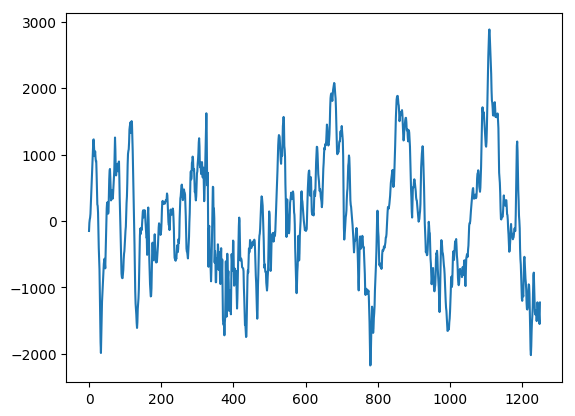

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1cc0392110>

In [22]:
plot(testsignal)